In [1]:
# CONTAINS ALL NECESSARY FUNCTIONALITY FOR THIS EXERCISE:
from Modules import OIP20_lib_ImageProcessing_V7_16bit as ip  
# (for this to work, you need:
#  * a subfolder named "Modules" in your Notebook folder
#  * in this subdfolder you need an empty file named "__init__.py"
#  * and of course the library (.py file) named "OIP20_lib_ImageProcessing_V1.py")

# if you want to use other functionality here, you need to load the libraries again: 
import matplotlib.pyplot as plt # We need this here only for closing the open windows
import numpy as np # we want to use some math...
from Modules import tictoc as t

# for nice(r) potting in the notebook
%matplotlib inline 

##  If not in Jupyter: close all open plots (otherwise you will get tons of them after some time...)
# plt.close("all")

# Some house holding: 
#  Higher resolution for figures:
%config InlineBackend.figure_format = 'retina' # (doubles the plot dpi)

# for interactive graphing: 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
particles_frequency_001 = np.load('./images/dataset/001_particles.npy')
diameter_frequency_001 = np.load('./images/dataset/001_diameter.npy')

In [3]:
particles_frequency_006 = np.load('./images/dataset/006_particles.npy')
diameter_frequency_006 = np.load('./images/dataset/006_diameter.npy')

In [4]:
particles_frequency = np.concatenate((particles_frequency_001,particles_frequency_006))
diameter_frequency = np.concatenate((diameter_frequency_001,diameter_frequency_006))

In [5]:
from matplotlib.ticker import MaxNLocator
import collections

def plot_result(result, xlabel='x', ylabel='y'):
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel, color='tab:blue')
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax[0].axvline(np.mean(result), color='k', linestyle='--', linewidth=3)
    ax[0].axvline(np.median(result), color='b', linestyle='-', linewidth=3)
    ax[0].text(np.mean(result), np.amax(result), 'Mean: {:.2f}'.format(np.mean(result)))
    ax[0].text(np.median(result), np.amax(result)*0.7, 'Median: {:.2f}'.format(np.median(result)))
    
#     np.amax(np.array(list()))
#     counts, bins = np.histogram(result, range=(np.array(list())))
#     ax[0].hist(bins[:-1], bins, weights=counts)
    hist = collections.Counter(result)
    ax[0].bar(hist.keys(),hist.values(),width=1)

    
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel, color='tab:blue')
    ax[1].boxplot(result, vert=False)
    
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel(ylabel, color='tab:blue')
    ax[2].violinplot(result, vert=False, showmeans=True,)
    plt.show()

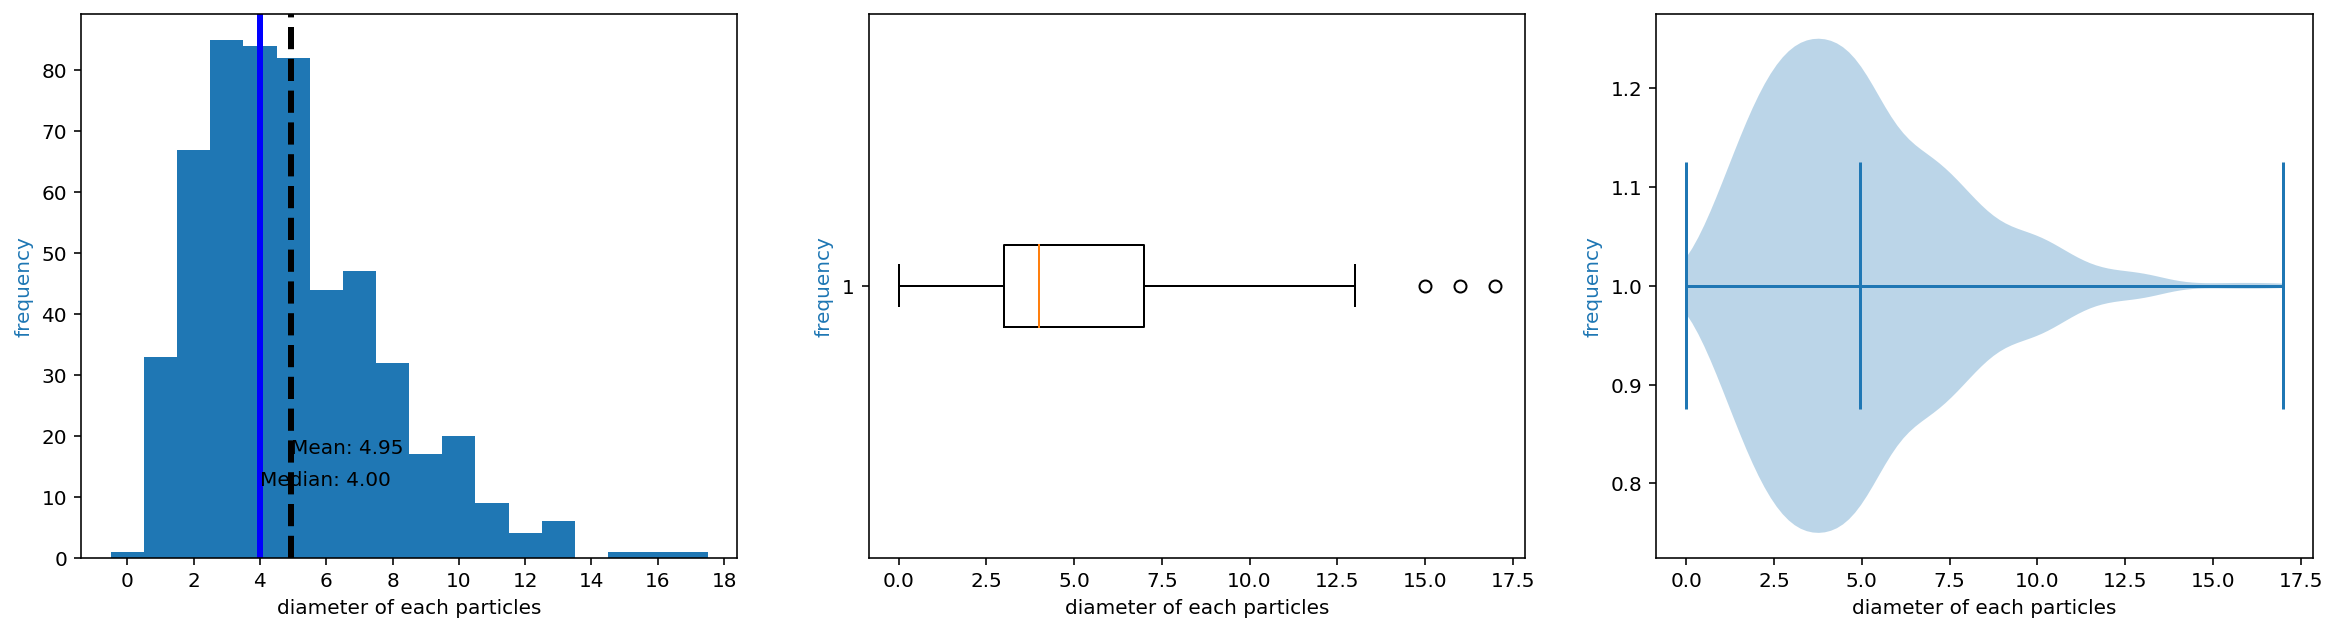

In [6]:
plot_result(particles_frequency, xlabel='diameter of each particles', ylabel='frequency')

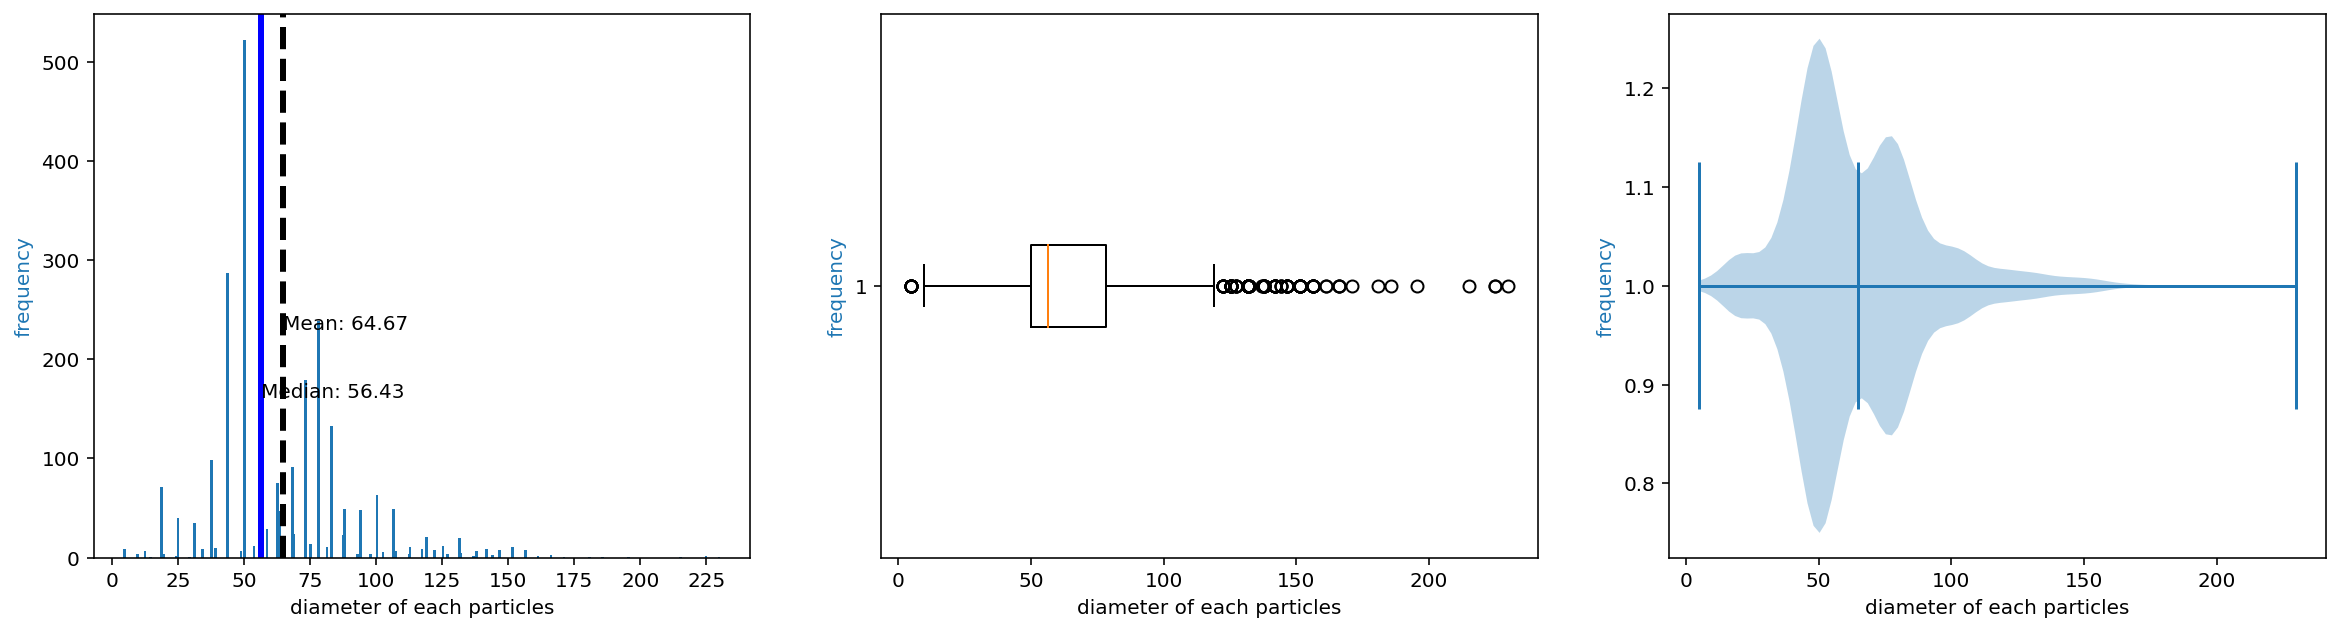

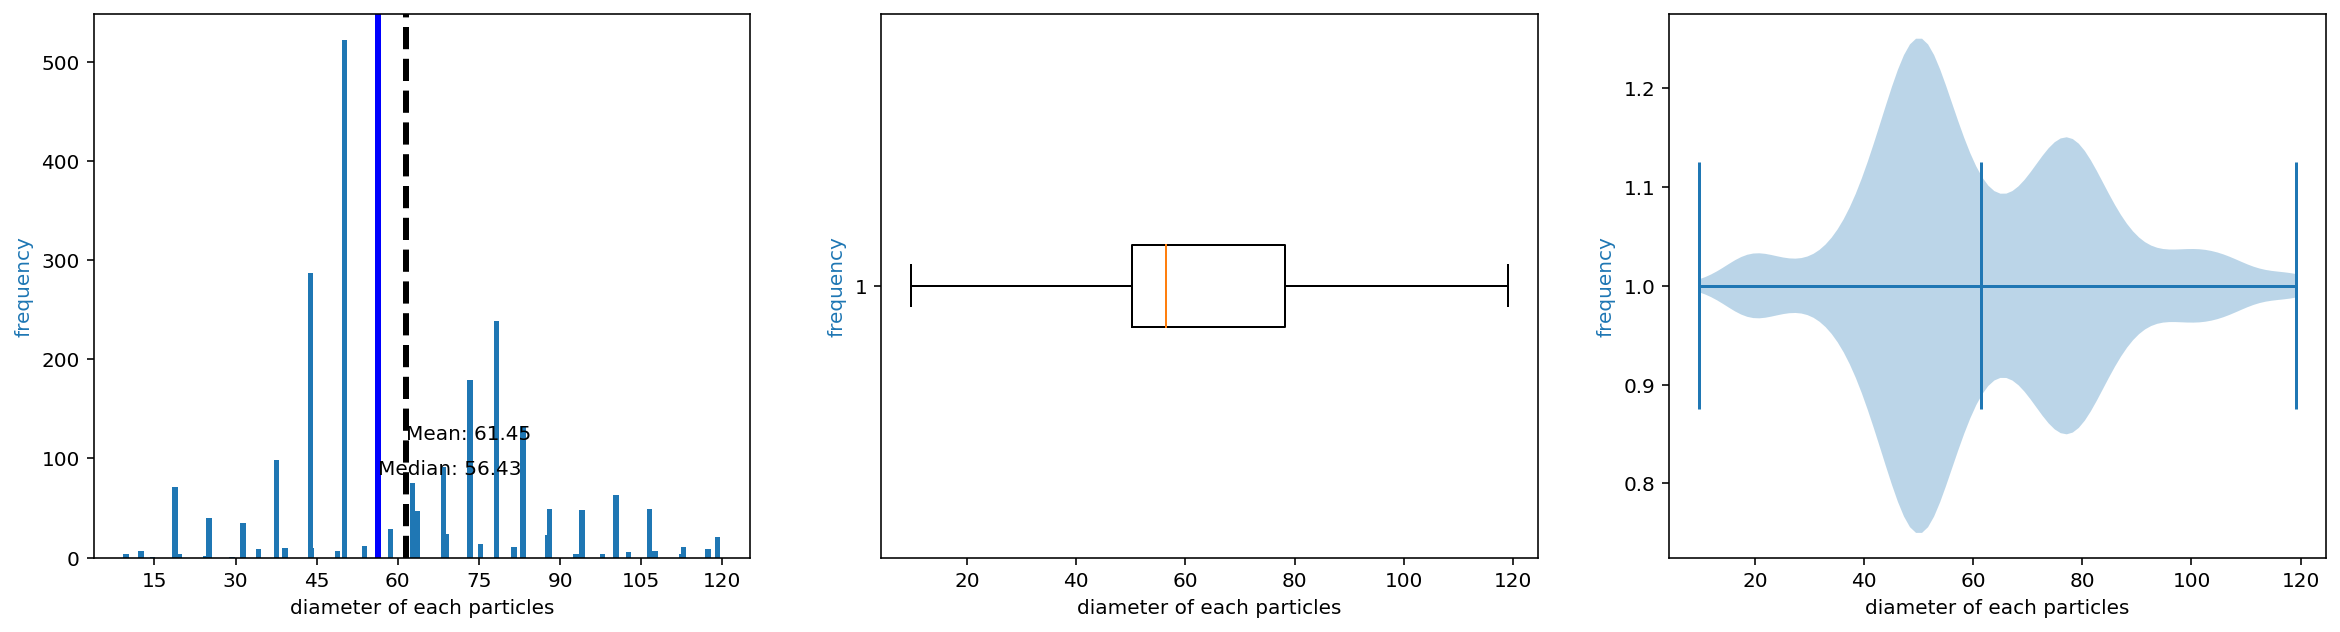

In [7]:
# remove outliers
diameter_frequency_1 = diameter_frequency[(diameter_frequency >= 5) & (diameter_frequency <= 120)]
plot_result(diameter_frequency, xlabel='diameter of each particles', ylabel='frequency')
plot_result(diameter_frequency_1, xlabel='diameter of each particles', ylabel='frequency')

In [8]:
def statistic(result):
#     print(result)
    print(np.mean(result)) # sum of all the entries divided by the number of entries / the average value 
    print(np.median(result)) # the middle point of the number of entries
    print(np.var(result)) # measures how far a set of numbers is spread out from their average value
    print(np.std(result)) # a measure of the amount of variation or dispersion of a set of values.

In [9]:
statistic(particles_frequency)

4.949438202247191
4.0
7.75212515254808
2.784263843917828


In [10]:
statistic(diameter_frequency)

64.6696869704177
56.426332288401255
724.4480997200399
26.915573553614642


In [11]:
statistic(diameter_frequency_1)

61.45099600799012
56.426332288401255
445.73656404124483
21.112474133583795


### Extract data
#### X1: number of particles of each cluster
#### X2: diameter of each particle

In [12]:
import collections 

std1 = np.std(particles_frequency)
mean1 = np.mean(particles_frequency)

hist1 = collections.Counter(particles_frequency)
sorted_hist1 = {i: hist1[i] for i in sorted(hist1)}
X1 = np.array(list(sorted_hist1.keys()))
Y1 = np.array(list(sorted_hist1.values()))
# print(X1)
# print(Y1)

In [13]:
std2 = np.std(diameter_frequency_1)
mean2 = np.mean(diameter_frequency_1)

hist2 = collections.Counter(diameter_frequency_1)
sorted_hist2 = {i: hist2[i] for i in sorted(hist2)}
X2 = np.array(list(sorted_hist2.keys()))
Y2 = np.array(list(sorted_hist2.values()))
# print(X2)
# print(Y2)

In [14]:
from sympy import *
A, B = symbols("A B")

### single gaussian peak
we use gaussian curve with only one peak to find the fitting function

In [15]:
std_sg = "global"
mean_sg = "global"
def sg_func(A, B, x):
    return (A/(std_sg*np.sqrt(2*np.pi)))*np.exp((-1/2)*((x-mean_sg)/std_sg)**2) + B

def sg_residual(A, B, x, y):
    return y - sg_func(A, B, x)

def sg_leastsq(A, B, x, y):
    return sum(sg_residual(A, B, x, y)**2)

In [22]:
def plot_single_curve(xnew, ynew, measuredX, measuredY, data, xlabel, ylabel):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,5))
    ax.scatter(measuredX, measuredY, marker= 'o')
    ax.plot(measuredX,sg_func(xnew, ynew, measuredX))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, color='tab:blue')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.axvline(np.mean(data), color='k', linestyle='--', linewidth=3)
    ax.axvline(np.median(data), color='b', linestyle='-', linewidth=3)
    ax.text(np.mean(data), np.amax(data), 'Mean: {:.2f}'.format(np.mean(data)))
    ax.text(np.median(data), np.amax(data)*0.7, 'Median: {:.2f}'.format(np.median(data)))

    hist = collections.Counter(data)
    ax.bar(hist.keys(),hist.values(),width=0.1)

Fitting function for number of particles of each cluster (particles_frequency)

In [23]:
std_sg = std1
mean_sg = mean1

In [24]:
# Newton_method
f = sg_leastsq(A, B, X1, Y1)
grad_f = Matrix([f]).jacobian([A, B])
grad_ff=hessian(f,[A,B]) ## Hessian  

In [25]:
X= np.array([[0.1],[0.2]]) ## Intial guess x_n
xk=X[0][0] ## Intial guess x_n
yk=X[1][0] ## Intial guess x_n
epsilon = 1e-6 # Pick the tolerance 
count = 0 # for the number of iteration 
nMax=30 # maximum number of iteration

In [26]:
while count < nMax:
    count += 1 # count the loop iterations...
    df = transpose(grad_f.subs({A:xk, B:yk}))
    dff = grad_ff.subs({A:xk, B:yk})
    H=np.array([[dff[0,0],dff[0,1]],[dff[1,0],dff[1,1]]])
    H=H.astype(float)
    xn=np.array([[xk],[yk]])
    X=X-np.linalg.inv(H)*df
    Xn=np.array(X)
    xk=Xn[0][0]
    yk=Xn[1][0]
    #error=np.sqrt((xk-xn[0][0])**2+(yk-xn[1][0])**2)
    print('Step: %i-- new guess x: %e-- new guess y: %e' %(count,xk,yk))

Step: 1-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 2-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 3-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 4-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 5-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 6-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 7-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 8-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 9-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 10-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 11-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 12-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 13-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 14-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 15-- new guess x: 5.386900e+02-- new guess y: 5.250074e-01
Step: 16-- new guess x: 5.386900e+

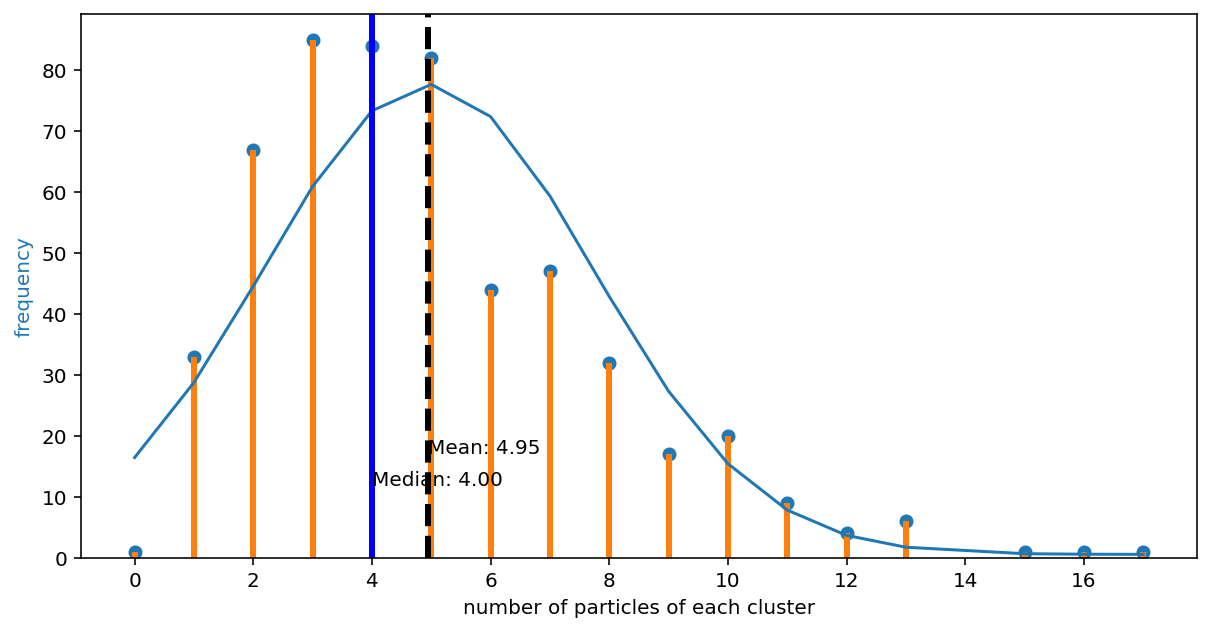

In [27]:
plot_single_curve(xk, yk, X1, Y1, particles_frequency, 'number of particles of each cluster', 'frequency')

As we see that, the fitting function with only one peak is inaccuracy because it cannot cover most of data points

Fitting function for diameter of each paricle (diameter_frequency)

In [28]:
std_sg = std2
mean_sg = mean2

In [29]:
f = sg_leastsq(A, B, X2, Y2)
grad_f = Matrix([f]).jacobian([A, B])
grad_ff=hessian(f,[A,B]) ## Hessian  

In [30]:
X= np.array([[1],[2]]) ## Intial guess x_n
xk=X[0][0] ## Intial guess x_n
yk=X[1][0] ## Intial guess x_n
# print(X[1][0])
epsilon = 1e-6 # Pick the tolerance 
count = 0 # for the number of iteration 
nMax=30 # maximum number of iteration

In [31]:
while count < nMax:
    count += 1 # count the loop iterations...
    df = transpose(grad_f.subs({A:xk, B:yk}))
    dff = grad_ff.subs({A:xk, B:yk})
    H=np.array([[dff[0,0],dff[0,1]],[dff[1,0],dff[1,1]]])
    H=H.astype(float)
    xn=np.array([[xk],[yk]])
    X=X-np.linalg.inv(H)*df
    Xn=np.array(X)
    xk=Xn[0][0]
    yk=Xn[1][0]
    #error=np.sqrt((xk-xn[0][0])**2+(yk-xn[1][0])**2)
    print('Step: %i-- new guess x: %e-- new guess y: %e' %(count,xk,yk))

Step: 1-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 2-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 3-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 4-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 5-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 6-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 7-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 8-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 9-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 10-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 11-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 12-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 13-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 14-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 15-- new guess x: 6.808182e+03-- new guess y: 1.613633e+00
Step: 16-- new guess x: 6.808182e+

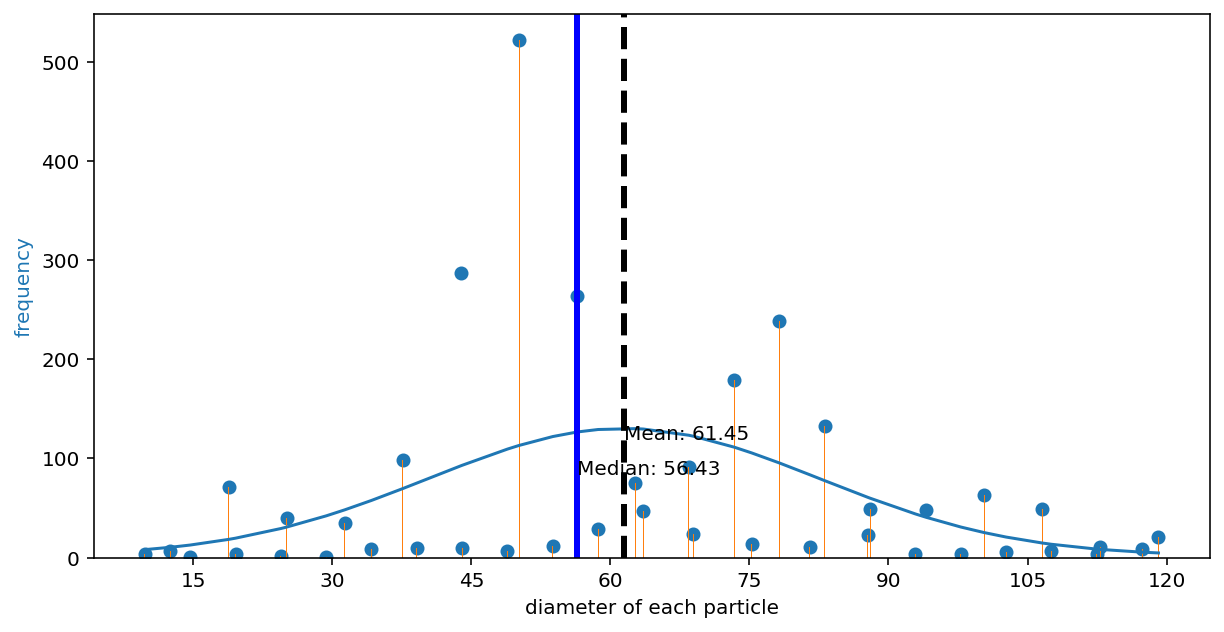

In [32]:
plot_single_curve(xk, yk, X2, Y2, diameter_frequency_1, 'diameter of each particle', 'frequency')

In this part, we use both sequence of Lorentzian curves and that of Gaussian curve with Newton_method and Nelder-Mead to get the best result.
Because the least square error function is unconstraint, we will use the optimisation algorithms for unconstraint function. Moreover, we need to find the local peak of the least square function.

### Sequence of Lorentzians

Particle

In [33]:
residualX = "global"
residualY = "global"
def lorent_func(x, p):
    cen1 = p[0]
    amp1 = p[1]
    wid1 = p[2]
    cen2 = p[3]
    amp2 = p[4]
    wid2 = p[5]
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) + \
            (amp2*wid2**2/((x-cen2)**2+wid2**2))
def lorent_residual(p):
    return residualY - lorent_func(residualX, p)
# least square
def lorent_leastsq(p):
    return sum(lorent_residual(p)**2)

In [34]:
from numdifftools import Jacobian, Hessian
# jacobian of calc_error function
def lorent_jac(p):
    return Jacobian(lambda p: lorent_leastsq(p))(p).ravel()
# hessian of calc_error function
def lorent_hess(p):
    return Hessian(lambda p: lorent_leastsq(p))(p) 

In [35]:
from scipy.interpolate import interp1d

def plot_lorent_fitting_func(args, measuredX, measuredY, data, xlabel, ylabel):
    y = lorent_func(measuredX, args)
    # smoothing the graph
    xnew = np.linspace(measuredX.min(), measuredX.max(), 100) # generate more x points based on the measuredX
    ynew = interp1d(measuredX, y, kind='quadratic') # get new y-value from generated x

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,5))
    ax.scatter(measuredX, measuredY, marker= 'o')
    ax.plot(xnew, ynew(xnew))
    # draw grid for checking and finding the initial points
    ax.set_xticks(np.arange(0, np.amax(measuredX), 5))
    ax.set_yticks(np.arange(0, np.amax(measuredY), np.amax(measuredY)/10))
    plt.grid()
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, color='tab:blue')
    # format the value of XY axis to integer
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # draw the mean and median lines
    ax.axvline(np.mean(data), color='k', linestyle='--', linewidth=3)
    ax.axvline(np.median(data), color='b', linestyle='-', linewidth=3)
    ax.text(np.mean(data), np.amax(particles_frequency), 'Mean: {:.2f}'.format(np.mean(data)))
    ax.text(np.median(data), np.amax(particles_frequency)*0.5, 'Median: {:.2f}'.format(np.median(data)))
#     hist = collections.Counter(data)
#     ax.bar(hist.keys(),hist.values(),width=0.2)

In [36]:
from scipy.optimize import minimize

In [37]:
residualX = X1
residualY = Y1
P0=np.array([3,84,0.1,
             7,45,0.1,
             10,20,0.1])
Resedual = minimize(lorent_leastsq, P0, method='Nelder-Mead' , tol=1e-1, options={'disp': True})
print(Resedual.x)

Optimization terminated successfully.
         Current function value: 334.935558
         Iterations: 1242
         Function evaluations: 1798
[-1.47734501e-01 -1.36249923e+02  6.18840764e+00  2.79611697e+00
  1.94073395e+02  4.32439240e+00 -2.09842802e+00 -8.99271187e+02
  1.79565044e+00]


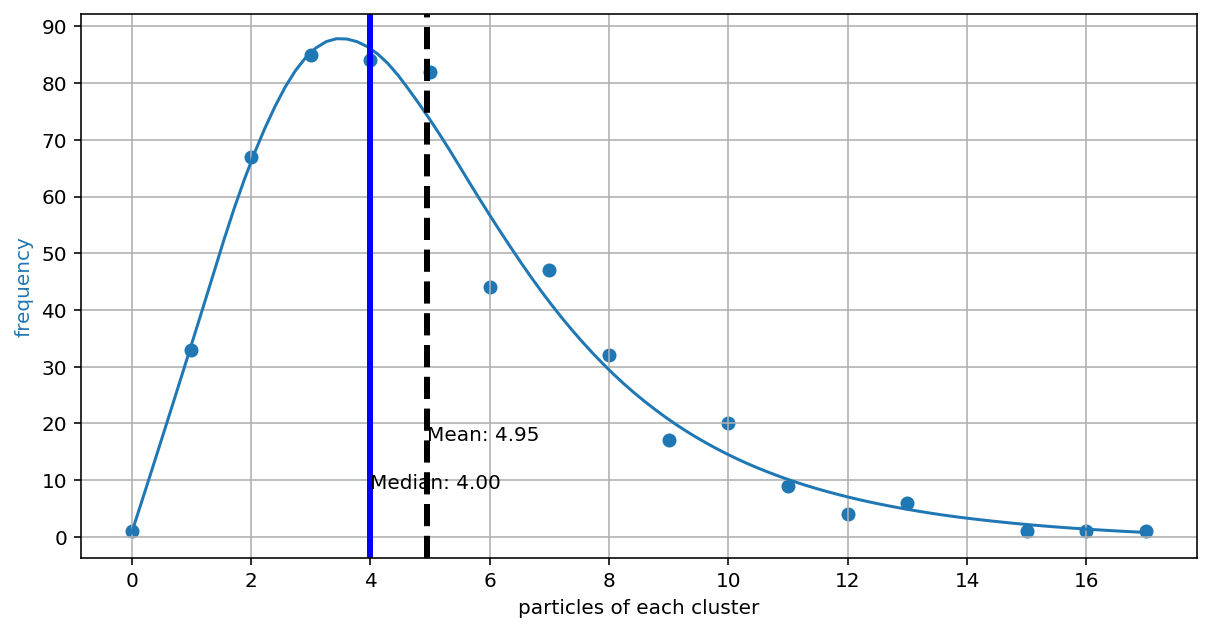

In [38]:
plot_lorent_fitting_func(Resedual.x, X1, Y1, particles_frequency,'particles of each cluster','frequency')

In [39]:
Resedual = minimize(lorent_leastsq, P0, method='Newton-CG',jac=lorent_jac, hess=lorent_hess ,options={'disp': True})

Optimization terminated successfully.
         Current function value: 746.093694
         Iterations: 127
         Function evaluations: 234
         Gradient evaluations: 360
         Hessian evaluations: 127


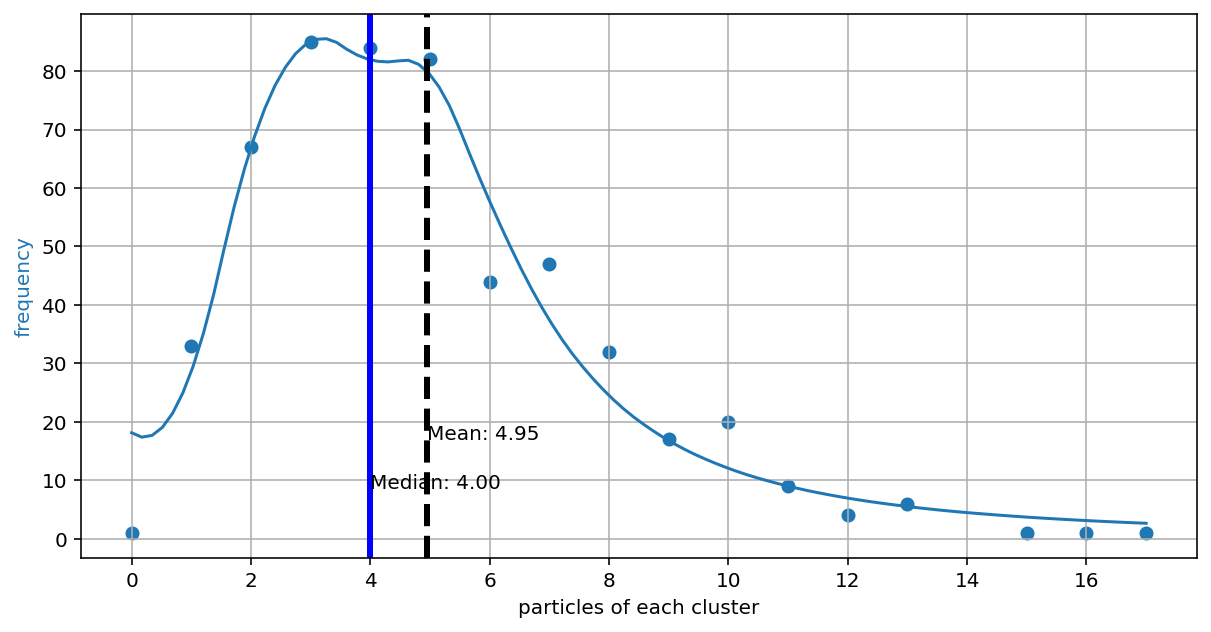

In [40]:
plot_lorent_fitting_func(Resedual.x, X1, Y1, particles_frequency,'particles of each cluster','frequency')

In [41]:
# from scipy.optimize.linesearch import line_search_armijo

# start_point =np.array([3,84,0.1,
# #              5,80,0.1,
#              7,45,0.1,
#              10,20,0.1])

# line_search_armijo(calc_error, opti_jac(start_point), start_point, -opti_jac(start_point), 
#                    old_fval=calc_error(start_point), alpha0=0.001)

Diameter

In [86]:
residualX = X2
residualY = Y2
# residualX = X2[(Y2 > 30)]
# residualY = Y2[(Y2 > 30)]

P0=np.array([
             50,522,5,
             78,239,5
            ])
NMResedual = minimize(lorent_leastsq, P0, method='Nelder-Mead' ,tol=1e-1,options={'disp': True})
print(NMResedual.x)

Optimization terminated successfully.
         Current function value: 278043.853558
         Iterations: 287
         Function evaluations: 432
[ 50.29967091 246.23256527   6.29959645  78.27327415 212.1217738
   2.45132445]


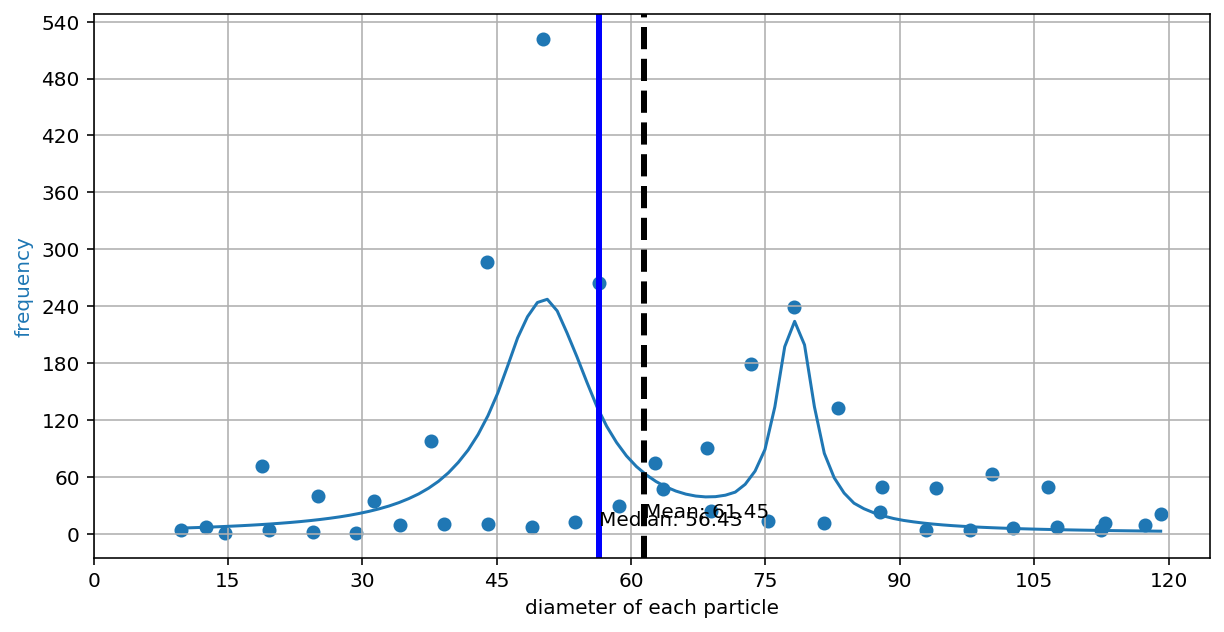

In [87]:
plot_lorent_fitting_func(NMResedual.x, residualX, residualY, diameter_frequency_1,'diameter of each particle','frequency')

In [58]:
def single_lorent_func(x, p):
    cen1 = p[0]
    amp1 = p[1]
    wid1 = p[2]
    return (amp1*wid1**2/((x-cen1)**2+wid1**2))

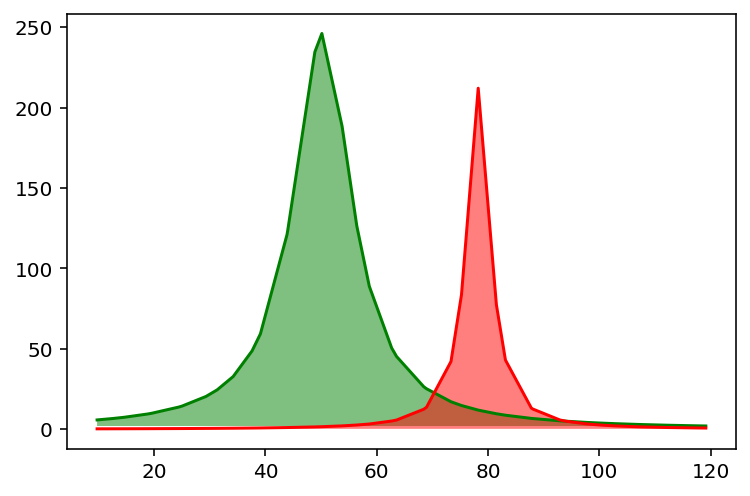

In [88]:
fig, ax = plt.subplots()
param_peak1 = NMResedual.x[0:3]
param_peak2 = NMResedual.x[3:6]
peak1 = single_lorent_func(residualX, param_peak1)
peak2 = single_lorent_func(residualX, param_peak2)
ax.plot(residualX, peak1 , "g")
ax.fill_between(residualX, peak1.min(), peak1, facecolor="green", alpha=0.5)
ax.plot(residualX, peak2 , "r")
ax.fill_between(residualX, peak2.min(), peak2, facecolor="red", alpha=0.5)

In [89]:
Resedual = minimize(lorent_leastsq, P0, method='Newton-CG',jac=lorent_jac, hess=lorent_hess , options={'maxiter':100,'disp': True})

         Current function value: 186753.471823
         Iterations: 100
         Function evaluations: 153
         Gradient evaluations: 252
         Hessian evaluations: 100


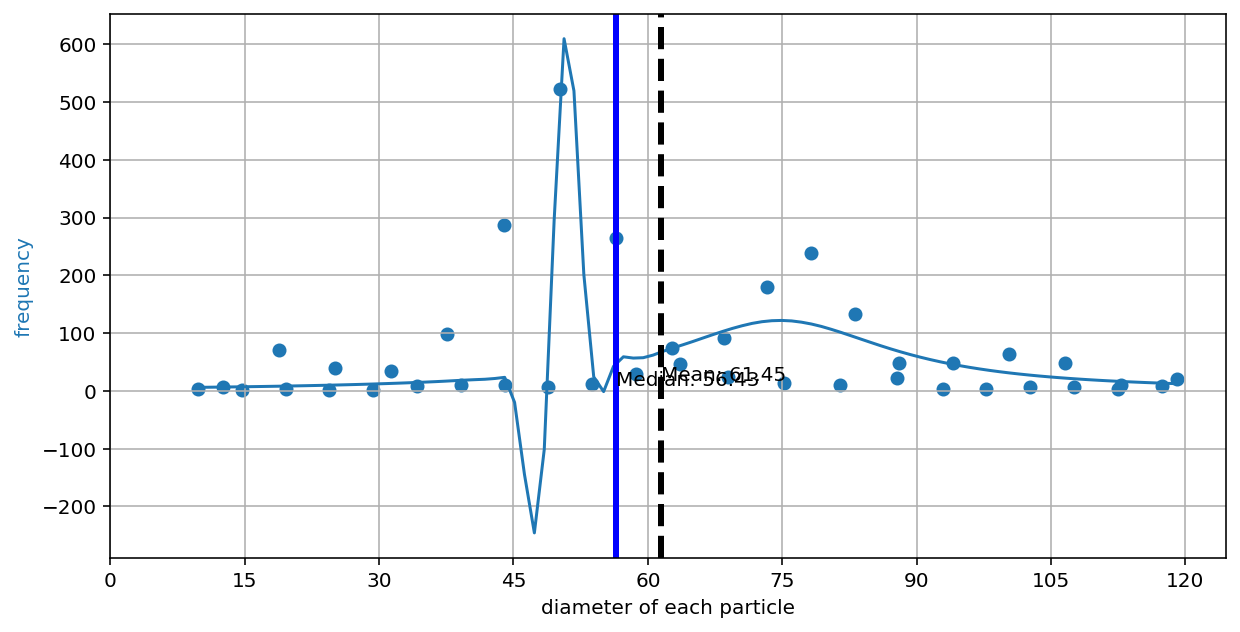

In [65]:
plot_lorent_fitting_func(Resedual.x, residualX, residualY, diameter_frequency_1,'diameter of each particle','frequency')

### Sequence of Gaussian

In [66]:
gresidualX = "global"
gresidualY = "global"

def gaussian_func(x, p):
    cen1=p[0]
    amp1=p[1]
    sigma1=p[2]
    cen2=p[3]
    amp2=p[4]
    sigma2=p[5]
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) \
            + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

def gaussian_residual(p):
    return gresidualY - gaussian_func(gresidualX, p)
# least square
def gaussian_leastsq(p):
    return sum(gaussian_residual(p)**2)

In [67]:
def plot_gaussian_fitting_func(args, measuredX, measuredY, data, xlabel, ylabel):
    y = gaussian_func(measuredX, args)
    
    xnew = np.linspace(measuredX.min(), measuredX.max(), 100)
    ynew = interp1d(measuredX, y, kind='quadratic')

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,5))
    ax.scatter(measuredX, measuredY, marker= 'o')
    ax.plot(xnew, ynew(xnew))
    ax.set_xticks(np.arange(0, np.amax(measuredX), 5))
    ax.set_yticks(np.arange(0, np.amax(measuredY), np.amax(measuredY)/10))
    plt.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, color='tab:blue')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.axvline(np.mean(data), color='k', linestyle='--', linewidth=3)
    ax.axvline(np.median(data), color='b', linestyle='-', linewidth=3)
    ax.text(np.mean(data), np.amax(particles_frequency), 'Mean: {:.2f}'.format(np.mean(data)))
    ax.text(np.median(data), np.amax(particles_frequency)*0.5, 'Median: {:.2f}'.format(np.median(data)))
#     hist = collections.Counter(data)
#     ax.bar(hist.keys(),hist.values(),width=0.2)

In [68]:
gresidualX = X2
gresidualY = Y2
P0=np.array([
             50,520,5,
             78,239,5
            ])
Resedual = minimize(gaussian_leastsq, P0, method='Nelder-Mead' ,tol=1e-8,options={'disp': True})
print(Resedual.x)

Optimization terminated successfully.
         Current function value: 291405.900391
         Iterations: 401
         Function evaluations: 701
[ 49.91245284 222.23025227   6.4701701   77.11007798 127.78541027
   7.30288512]


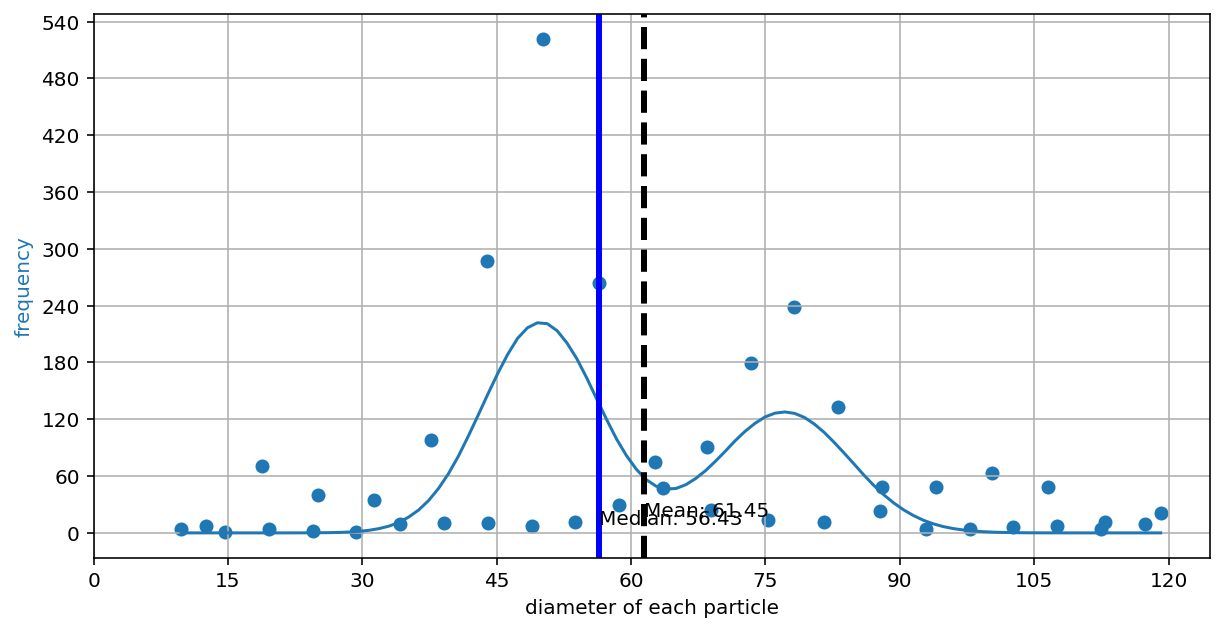

In [69]:
plot_gaussian_fitting_func(Resedual.x, gresidualX, gresidualY, diameter_frequency_1,'diameter of each particle','frequency')

In [73]:
# jacobian of calc_error function
def gaus_jac(p):
    return Jacobian(lambda p: gaussian_leastsq(p))(p).ravel()
# hessian of calc_error function
def gaus_hess(p):
    return Hessian(lambda p: gaussian_leastsq(p))(p) 

In [82]:
def single_gaussian_func(x, p):
    cen1 = p[0]
    amp1 = p[1]
    sigma1 = p[2]
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

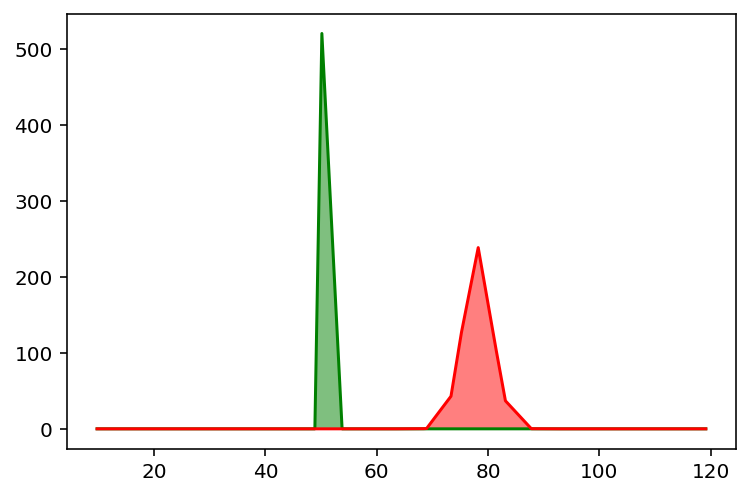

In [83]:
fig, ax = plt.subplots()
param_peak1 = Resedual.x[0:3]
param_peak2 = Resedual.x[3:6]
peak1 = single_gaussian_func(gresidualX, param_peak1)
peak2 = single_gaussian_func(gresidualX, param_peak2)
ax.plot(gresidualX, peak1 , "g")
ax.fill_between(gresidualX, peak1.min(), peak1, facecolor="green", alpha=0.5)
ax.plot(gresidualX, peak2 , "r")
ax.fill_between(gresidualX, peak2.min(), peak2, facecolor="red", alpha=0.5)

In [ ]:
Resedual = minimize(gaussian_leastsq, P0, method='Newton-CG',jac=gaus_jac, hess=gaus_hess ,options={'maxiter':100,'disp': True})

# For testing only, don't add to the report

In [84]:
P0=np.array([
             50,520,3,
             78,239,2
            ])

def gaussian_func_2(x, cen1, amp1, sigma1, cen2, amp2, sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) \
            + amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2))) \
#             + amp3*(1/(sigma3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2))) \
#             + amp4*(1/(sigma4*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))
#             + amp5*(1/(sigma5*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen5)/sigma5)**2)))

def single_gaussian_func(x, cen1, amp1, sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

[  49.91252794 3604.30660571    6.47046884   77.11006633 2339.03187987
    7.30198472]


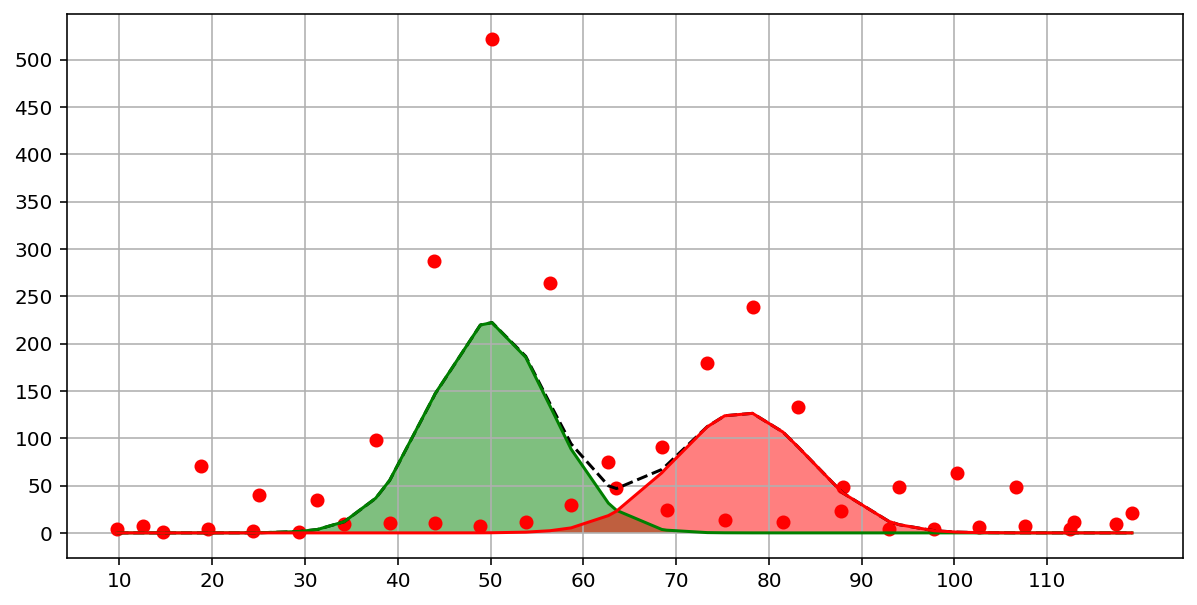

In [85]:
from scipy.optimize import curve_fit
popt_2gauss, pcov_2gauss = curve_fit(gaussian_func_2, gresidualX, gresidualY, p0=P0)
print(popt_2gauss)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,5))
ax.set_xticks(np.arange(0, 120, 10))
ax.set_yticks(np.arange(0, 550, 50))
plt.grid()
ax.plot(gresidualX, gresidualY, "ro")
ax.plot(gresidualX, gaussian_func_2(gresidualX, *popt_2gauss), 'k--')

a = [49.9,3604,6.47]
b = [77.1,2339,7.3]
peak1 = single_gaussian_func(gresidualX,*a)
peak2 = single_gaussian_func(gresidualX,*b)
ax.plot(gresidualX, peak1 , "g")
ax.fill_between(X2, peak1.min(), peak1, facecolor="green", alpha=0.5)
ax.plot(gresidualX, peak2 , "r")
ax.fill_between(X2, peak2.min(), peak2, facecolor="red", alpha=0.5)